In [20]:
from fastai.vision.all import *
from utils import *
import random
#### to handle broken files ###
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split
ImageFile.LOAD_TRUNCATED_IMAGES = True
def verify_image(fn):
    "Confirm that `fn` can be opened"
    try:
        im = Image.open(fn)  # uses PIL.Image to open an image at fn
        im.draft(im.mode, (32,32)) 
        im.load()
        return True
    except: return False
    
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)

###################################

# 1. Original Dataset with 27 locations

In [2]:
main_dir = Path(r"D:\0_Bike_reid_dataset")

In [3]:
main_df = get_bike_nobike_df(main_dir)
main_df.head()

,loc_id,Bicyclist,No_Bicyclist,Set
0,Loc_01,224,4385,NaN
1,Loc_02,8,4029,NaN
2,Loc_03,813,7514,NaN
3,Loc_04,1473,8482,NaN
4,Loc_05,678,1675,NaN


In [5]:
total_bike_ims = main_df['Bicyclist'].sum()
total_nobike_ims = main_df['No_Bicyclist'].sum()
total_bike_ims, total_nobike_ims

(8454, 265999)

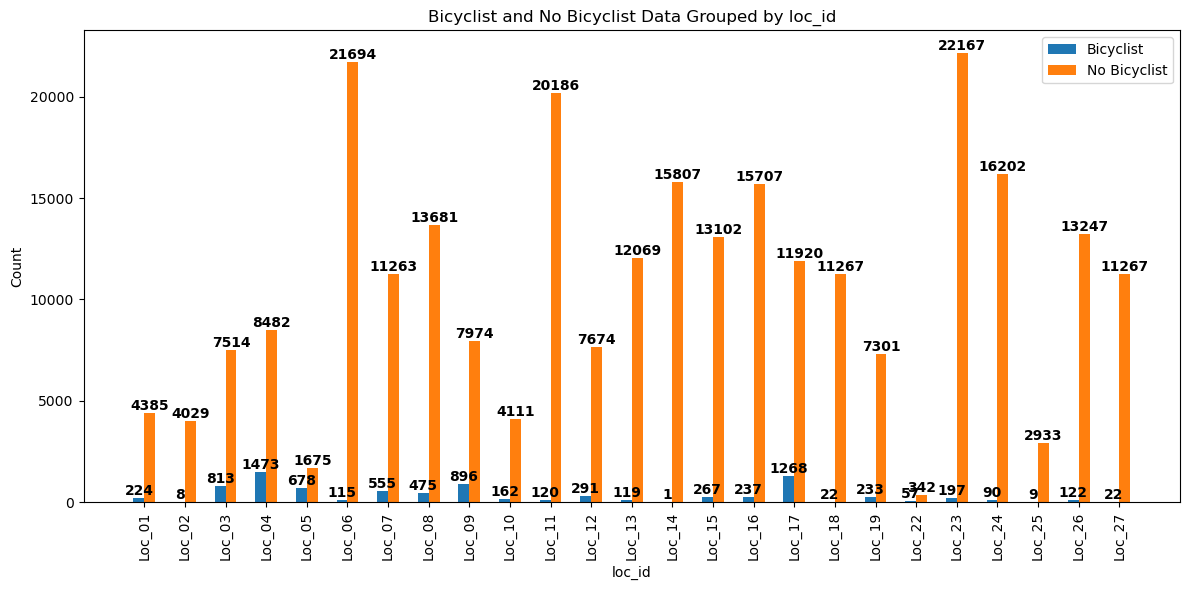

In [6]:
plot_bike_nobike_data(main_df)

# 2. Classification Dataset (11 locations)
- subset of Original dataset
- Val locations entered **manually** for reproducibility

In [60]:
loc_nums = ['01', '04', '06', '09', '12', '15', '17', '20', '21', '22', '24']

In [61]:
df = get_df_from_loc_nums(main_dir, loc_nums)
df.head()

,loc_id,Bicyclist,No_Bicyclist,Set
0,Loc_01,224,4385,NaN
1,Loc_04,1473,8482,NaN
2,Loc_06,115,21694,NaN
3,Loc_09,896,7974,NaN
4,Loc_12,291,7674,NaN


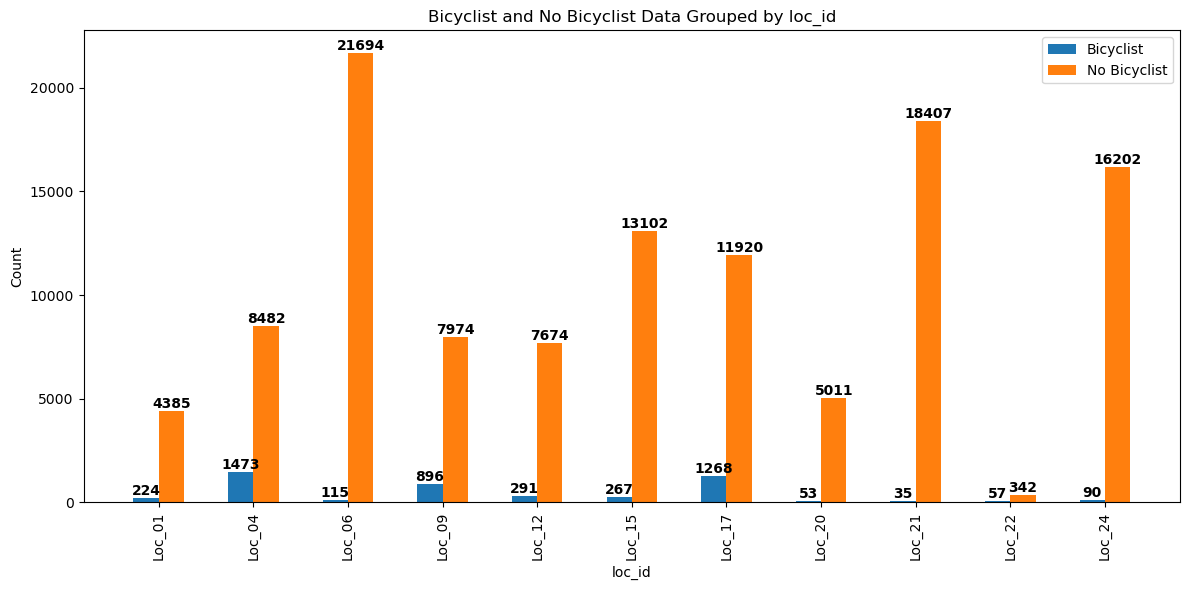

In [63]:
plot_bike_nobike_data(df)

### 2.1 Creating a dataset with balanced classes

In [64]:
out_dir = Path("D:/A1_Classification_DS")

In [65]:
## Run only once to with create_new = True
#make_balanced_dataset(main_dir, loc_nums, out_dir, create_new= False)

In [66]:
all_bike_folders, all_nobike_folders = find_bike_nobike_folders(out_dir)
len(all_bike_folders), len(all_nobike_folders)

(11, 11)

In [67]:
# check
all_bike_imgs  = L([get_image_files(o) for o in all_bike_folders]) # nested list
all_nobike_imgs = L([get_image_files(o) for o in all_nobike_folders]) # nested list

for b, nb in zip(all_bike_imgs, all_nobike_imgs):
    print(len(b), len(nb))

224 224
1473 1473
115 115
896 896
291 291
267 267
1268 1268
53 53
35 35
57 57
90 90


In [68]:
# flattened lists
all_bike_imgs = L([s for f in all_bike_imgs for s in f])
all_nobike_imgs = L([s for f in all_nobike_imgs for s in f])

# check
print(len(all_bike_imgs), len(all_nobike_imgs))
print('Sample: ', all_bike_imgs[:2], all_nobike_imgs[:2])

4769 4769
Sample:  [Path('D:/A1_Classification_DS/Loc_01/Bicyclist/IM_00165.JPG'), Path('D:/A1_Classification_DS/Loc_01/Bicyclist/IM_00167.JPG')] [Path('D:/A1_Classification_DS/Loc_01/No_Bicyclist/IM_00288.JPG'), Path('D:/A1_Classification_DS/Loc_01/No_Bicyclist/IM_00376.JPG')]


In [69]:
# save_pickle(all_bike_imgs, 'all_bike_images')
# save_pickle(all_nobike_imgs, 'all_nobike_images')

In [70]:
# check
# # Run when required: Else it takes time to verify
# failed_bike_ims = verify_images(all_bike_imgs)
# failed_nobike_ims = verify_images(all_nobike_imgs)

# print(len(failed_bike_ims), len(failed_nobike_ims))

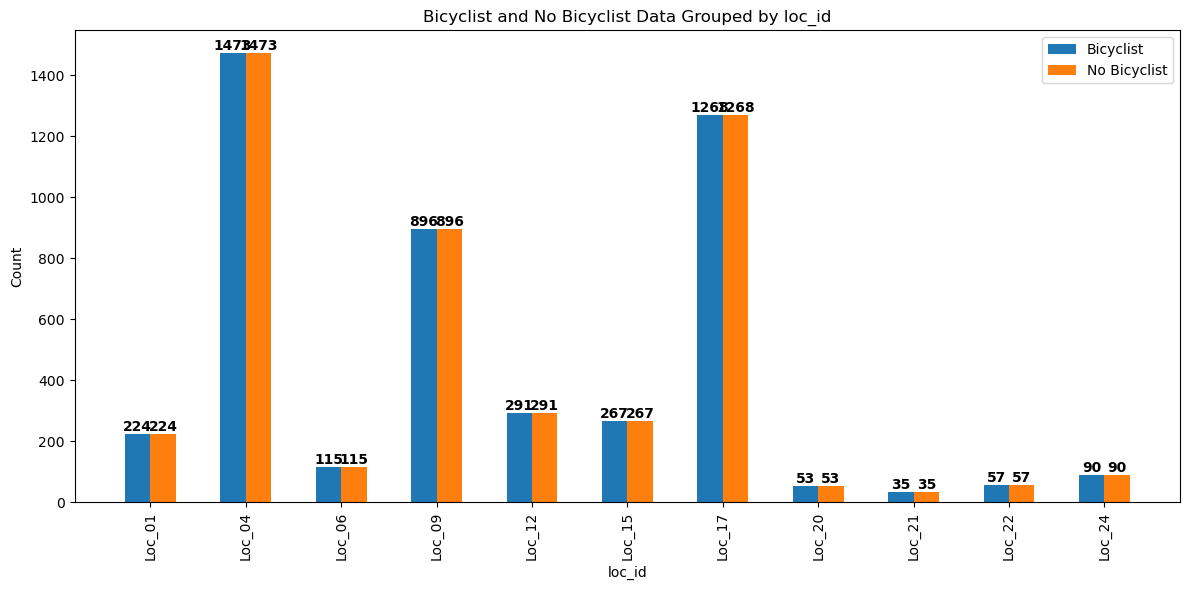

In [71]:
df2 = df.copy()
df2['No_Bicyclist'] = df2['Bicyclist']
plot_bike_nobike_data(df2)

### 2.2 Split into train and validation

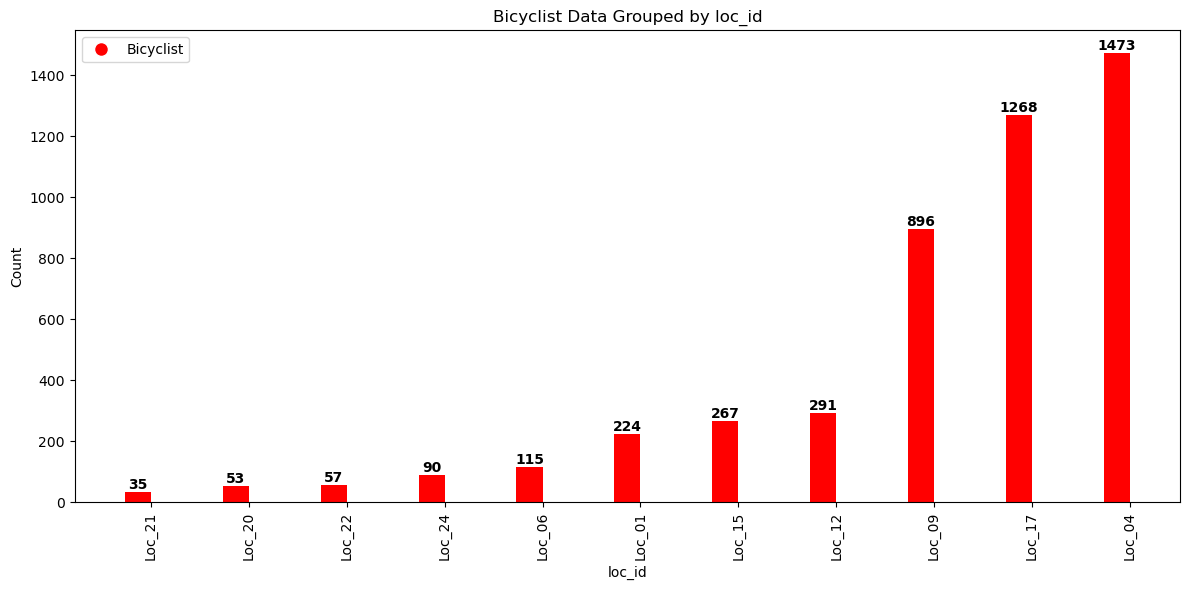

In [72]:
plot_sorted_bike_data(df2)

In [73]:
val_locs = ['09', '15', '21']
df3 = df2.copy()

for idx, row in df3.iterrows():
    if row['loc_id'][-2:] in val_locs:
        row['Set'] = 'Val'
    else:
        row['Set'] = 'Train'
        
df3

,loc_id,Bicyclist,No_Bicyclist,Set
0,Loc_01,224,224,Train
1,Loc_04,1473,1473,Train
2,Loc_06,115,115,Train
3,Loc_09,896,896,Val
4,Loc_12,291,291,Train
5,Loc_15,267,267,Val
6,Loc_17,1268,1268,Train
7,Loc_20,53,53,Train
8,Loc_21,35,35,Val
9,Loc_22,57,57,Train


In [74]:
train_df = df3[df3['Set']=='Train']
val_df = df3[df3['Set']=='Val']

num_train_bikes = sum(train_df['Bicyclist'])
num_val_bikes = sum(val_df['Bicyclist'])
print('Bicyclist Images in Train: ', num_train_bikes, '\nBicyclist Images in Val: ',num_val_bikes,
      '\n Train = {}%'.format(num_train_bikes*100/(num_train_bikes + num_val_bikes)))

Bicyclist Images in Train:  3571 
Bicyclist Images in Val:  1198 
 Train = 74.87942964982176%


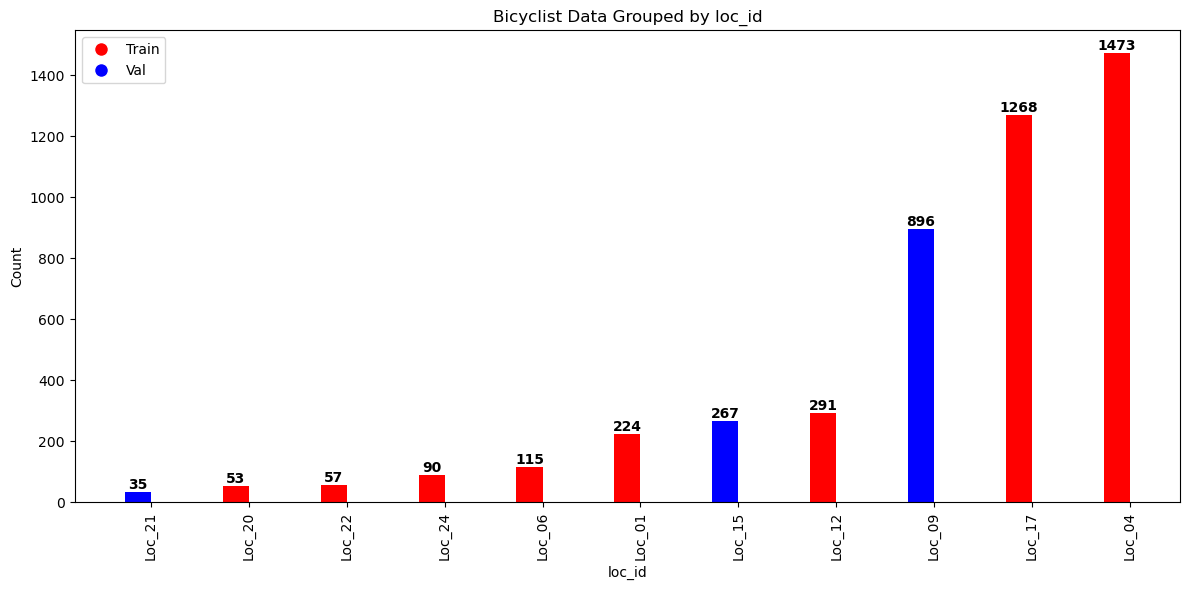

In [75]:
plot_sorted_bike_data(df3, train_val=True)

### 2.3 O2I plotter

# 3. Model Training

In [76]:
fnames = all_bike_imgs + all_nobike_imgs
random.shuffle(fnames) # mix bike and nobike images

# check
labels = [parent_label(x) for x in fnames]
labels = L(labels) # convert into fastai list
labels[:8]

(#8) ['Bicyclist','Bicyclist','Bicyclist','Bicyclist','No_Bicyclist','No_Bicyclist','Bicyclist','No_Bicyclist']

In [77]:
val_locations = list(df3[df3['Set']=='Val'].loc_id)
train_locations = list(df3[df3['Set']=='Train'].loc_id)
val_locations

['Loc_09', 'Loc_15', 'Loc_21']

In [78]:
def label_func(fname):
    return parent_label(fname)

def custom_splitter(item):
    grandparent_folder = item.parent.parent.name
    return grandparent_folder in val_locations

# Note: if value of custom_splitter is True the item is added to validation else into train set

# Now define how we want to split our dataset into train and val
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                   get_y = label_func,
                  splitter =FuncSplitter(custom_splitter),
                  item_tfms=Resize((272,480), ResizeMethod.Squish))

# create dataset
dsets = dblock.datasets(fnames) 

C:\ProgramData\Anaconda3\envs\fai\lib\site-packages\fastai\data\transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


In [79]:
dsets.valid

(#2396) [(PILImage mode=RGB size=1920x1088, TensorCategory(1)),(PILImage mode=RGB size=1920x1088, TensorCategory(1)),(PILImage mode=RGB size=1920x1088, TensorCategory(1)),(PILImage mode=RGB size=1920x1088, TensorCategory(1)),(PILImage mode=RGB size=1920x1088, TensorCategory(1)),(PILImage mode=RGB size=1920x1088, TensorCategory(0)),(PILImage mode=RGB size=1920x1088, TensorCategory(0)),(PILImage mode=RGB size=1920x1088, TensorCategory(1)),(PILImage mode=RGB size=1920x1088, TensorCategory(0)),(PILImage mode=RGB size=1920x1088, TensorCategory(0))...]

In [81]:
dsets.train

(#7142) [(PILImage mode=RGB size=1920x1088, TensorCategory(0)),(PILImage mode=RGB size=1920x1088, TensorCategory(0)),(PILImage mode=RGB size=1920x1088, TensorCategory(0)),(PILImage mode=RGB size=1920x1088, TensorCategory(0)),(PILImage mode=RGB size=1920x1088, TensorCategory(1)),(PILImage mode=RGB size=1920x1088, TensorCategory(0)),(PILImage mode=RGB size=1920x1088, TensorCategory(1)),(PILImage mode=RGB size=1920x1088, TensorCategory(0)),(PILImage mode=RGB size=1920x1088, TensorCategory(0)),(PILImage mode=RGB size=1920x1088, TensorCategory(0))...]

In [82]:
dsets.vocab

['Bicyclist', 'No_Bicyclist']

#### 3.1 Customisable Datablock

# Object Detection Dataset Pre-Processing

In [3]:
my_dir = Path(r"D:\P2_Yolo_All\All_minus")

In [17]:
def get_image_txt_files(path):
    '''input - path to main folder
    output - list of all images and txts as paths'''
    
    images = get_image_files(path)
    txt_files = list(path.rglob("*.txt"))
    print('Total txt files: ',len(txt_files)); print('Total Images: ', len(images))
    
    return images, txt_files

def check_missing_txts(im_paths, txt_paths):
    txt_fnames = [f.name[:-4] for f in txt_paths]
    im_names = [f.name[:-4] for f in im_paths]
    
    imgs_missing_txts = []
    for o in im_names:
        if o not in txt_fnames:
            imgs_missing_txts.append(o)
    print('Images without label: ', len(imgs_missing_txts))
    return imgs_missing_txts

def check_missing_jpgs(im_paths, txt_paths):
    txt_fnames = [f.name[:-4] for f in txt_paths]
    im_names = [f.name[:-4] for f in im_paths]
    
    txts_missing_imgs = []
    for o in txt_fnames:
        if o not in im_names:
            txts_missing_imgs.append(o)
    print('Image Not found: ', txts_missing_imgs)
    return txts_missing_imgs

def check_label_class(txt_files):
    ''' check if all labels start from 0 and not 15'''
    files_to_correct = []
    for o in txt_files:
        with open(o, 'r') as file:
            lines = file.readlines()
            modified_lines = []
            for line in lines:
                if not line.startswith('0'):
                    files_to_correct.append(o)

    print('Txt files with incorrect class labels: ', len(files_to_correct))
    

    return files_to_correct
          

    
def rectify_15(files_to_correct):
    ''' change files whose class start with 15 to 0'''
    for o in files_to_correct:
        with open(o, 'r') as file:
            lines = file.readlines()
            modified_lines = []
            for line in lines:
                if line.startswith('15'):
                    modified_line= '0'+ line[2:]
                else:
                    modified_line = line
                modified_lines.append(modified_line)
            with open(o, 'w') as file:
                file.writelines(modified_lines)

In [5]:
all_ims, all_txts = get_image_txt_files(my_dir)

Total txt files:  3723
Total Images:  4759


In [10]:
imgs_missing_txts = check_missing_txts(all_ims, all_txts)
txts_missing_imgs = check_missing_jpgs(all_ims, all_txts)

Images without label:  1037
Image Not found:  ['Loc_22_IM_00183']


In [12]:
def move_sane_im_label_data(im_paths, txt_paths, out_dir):
    ''' inputs-
    im_paths as list
    txt_paths as list
    out_dir - path to output directory
    '''
    txt_fnames = [f.name[:-4] for f in txt_paths]
    
    # check if for an image the label exists
    for im in im_paths:
        fname = im.name
        if fname[:-4] in txt_fnames:
            im_src = im
            im_dest = out_dir/im_src.name
            shutil.move(im_src, im_dest)     
            
            txt_src = Path(str(im)[:-4]+'.txt')
            txt_dest = out_dir/txt_src.name
            shutil.move(txt_src, txt_dest)
    print('Done!!')

### Move sane data
- [x] Careful when running

In [13]:
out_dir = Path(r"D:\P2_Yolo_All\Labelled_DS")
## Run when required
#move_sane_im_label_data(all_ims, all_txts, out_dir)

Done!!


In [14]:
# check
labelled_ims, labelled_txts = get_image_txt_files(out_dir)
imgs_missing_txts = check_missing_txts(labelled_ims, labelled_txts)
txts_missing_imgs = check_missing_jpgs(labelled_ims, labelled_txts)

Total txt files:  3722
Total Images:  3722
Images without label:  0
Image Not found:  []


#### check for correct label: 0 and not 15

In [16]:
files_to_correct = check_label_class(labelled_txts)

Txt files with incorrect class labels:  0


In [ ]:
## Run if required
#rectify_15(files_to_correct)

In [ ]:
## check AGAIN
# labelled_ims, labelled_txts = get_image_txt_files(out_dir)
# imgs_missing_txts = check_missing_txts(labelled_ims, labelled_txts)
# txts_missing_imgs = check_missing_jpgs(labelled_ims, labelled_txts)
# files_to_correct = check_label_class(labelled_txts)

### Split dataset for Yolo training
- For now it is random

In [19]:
path = Path(r'D:\P2_Yolo_All\Yolo_train')  # Use raw string for Windows paths

train_dir_im = path / 'images/train'
val_dir_im = path / 'images/val'
train_dir_label = path / 'labels/train'
val_dir_label = path / 'labels/val'

# Create parent directories if they don't exist
path.mkdir(parents=True, exist_ok=True)
train_dir_im.mkdir(parents=True, exist_ok=True)
val_dir_im.mkdir(parents=True, exist_ok=True)
train_dir_label.mkdir(parents=True, exist_ok=True)
val_dir_label.mkdir(parents=True, exist_ok=True)


In [21]:
X_train, X_test, y_train, y_test = train_test_split( labelled_ims, labelled_txts, test_size=0.20, random_state=42)

In [22]:
# # copy files

# for o in X_train:
#     src = o
#     dest = train_dir_im/o.name
#     shutil.copy(src, dest)
    
# for o in y_train:
#     src = o
#     dest = train_dir_label/o.name
#     shutil.copy(src, dest)

    
# for o in X_test:
#     src = o
#     dest = val_dir_im/o.name
#     shutil.copy(src, dest)
    
    
# for o in y_test:
#     src = o
#     dest = val_dir_label/o.name
#     shutil.copy(src, dest)
    
    